In [1]:
# Import required libraries
from imdclient.IMDREADER import IMDReader
import MDAnalysis as mda
import logging
import matplotlib.pyplot as plt
import numpy as np
import subprocess
import os
import numpy as np
import matplotlib.pyplot as plt
import threading
import time
from IPython.display import display

NAMD_TOPOL = "../exec-files/T3_MNN.psf"

# Set up logging
logger = logging.getLogger("imdclient.IMDClient")
file_handler = logging.FileHandler("imdreader.log")
formatter = logging.Formatter("%(asctime)s - %(name)s - %(levelname)s - %(message)s")
file_handler.setFormatter(formatter)
logger.addHandler(file_handler)
logger.setLevel(logging.DEBUG)

In [2]:
# Function to update the plot dynamically
def update_plot(x_data, y_data):
    """
    Update the plot with new data.

    Args:
        x_data (list): Frame numbers.
        y_data (list): Distances between Atom 1 and Atom 3.
    """
    line.set_data(x_data, y_data)  # Efficiently update the line with all data
    # ax.set_xlim(0, max(200,max(x_data)+100))  # Adjust X-axis dynamically
    fig.canvas.draw_idle()  # Efficient redraw
    # ax.draw_artist(line)
    # fig.canvas.blit(ax.bbox)

# Function to compute distances and update the plot
def read_and_plot(update_frequency=100):
    x_data = np.zeros(144000) #np.array([])  # Use NumPy arrays
    y_data = np.zeros(144000) #np.array([])

    i = 0

    timestep = 2.0 # timestep passed to NAMD in conf file
    framediff = 1 # IMDfreq
    skip = 1 # if any frames need to be skipped

    chargeFactor = 1.6022e-19/1.0e-9/1.0e-9   #It's in nanoamps
    dt = 1.0*timestep*framediff*skip/1.0e6
    ionText = "name POT CLA CAL SOD LIT CES IOD BRO H11 H21 H31 H41"
    ions = u.select_atoms(ionText)
    charge = ions.charges
    dims = ions.dimensions
    zdist = dims[2]

    for t in u.trajectory:
        newPos = ions.positions
        if i == 0:
            ionPos = newPos
        else:
            deltas = newPos[:,2]-ionPos[:,2]
            deltas[deltas>zdist/2.] = deltas[deltas>zdist/2.] - zdist
            deltas[deltas<-zdist/2.] = deltas[deltas<-zdist/2.] + zdist
            cd = deltas*charge
            tCur = np.sum(cd)/zdist/dt*chargeFactor
            ionPos = newPos
            time = round(dt * i - dt/2, 4)
            x_data[i] = i + 1
            y_data[i] = tCur
        i = i + 1

        # Update the plot periodically
        if i % update_frequency == 0:
            logger.info(f"Updating plot at frame {i}.")
            update_plot(x_data[:i], y_data[:i])

    logger.info(f"Processed {i} frames.")

# Thread function to process trajectory data
def start_thread(update_frequency=100):
    """
    Start a thread for reading trajectory and updating the plot.

    Args:
        update_frequency (int): Number of frames to process before updating the plot.
    """
    data_thread = threading.Thread(target=read_and_plot, args=(update_frequency,))
    data_thread.daemon = True  # Thread exits when main program ends
    data_thread.start()

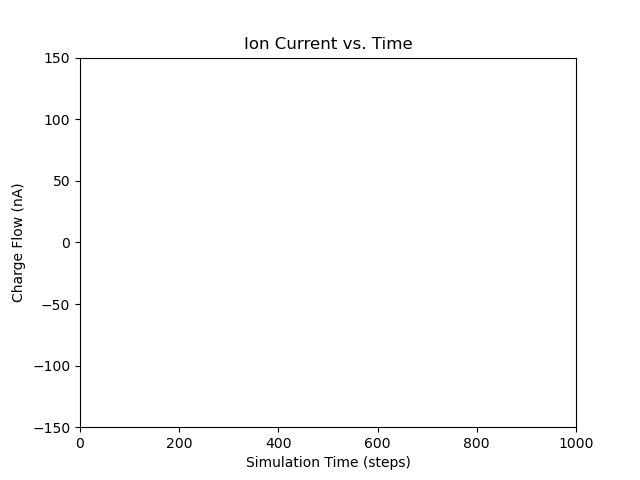

In [ ]:
# Initialize MDAnalysis Universe
u = mda.Universe(NAMD_TOPOL, "imd://localhost:9918")

# Enable interactive plotting
%matplotlib widget
plt.ion()

# Initialize the plot
fig, ax = plt.subplots()
line, = ax.plot([], [], lw=2)  # Line for dynamic updates
ax.set_xlim(0, 1000)  # Adjust as necessary
ax.set_ylim(-150, 150)  # Adjust based on expected distance range
ax.set_xlabel("Simulation Time (steps)")
ax.set_ylabel("Charge Flow (nA)")
ax.set_title("Ion Current vs. Time")

# Display the plot
# display(fig)

# Start the processing thread
start_thread(update_frequency=1)  # Update the plot every few frames